In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import keras
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPool2D
from keras.models import Sequential
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt 

# loading  the data

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Shape of training data and labels are - ',X_train.shape,y_train.shape)
print('Shape of test data and labels are - ',X_test.shape,y_test.shape)

170500096/170498071 [==============================] - 3s 0us/step
Shape of training data and labels are -  (50000, 32, 32, 3) (50000, 1)
Shape of test data and labels are -  (10000, 32, 32, 3) (10000, 1)


In [6]:
# lets look at training data into much more detail 
print('Training Data - ')
print('Nummber of images - ',X_train.shape[0])
print('Dimensions of an image - ',X_train.shape[1:3])
print('Number of channels - ',X_train.shape[-1])

Training Data - 
Nummber of images -  50000
Dimensions of an image -  (32, 32)
Number of channels -  3


Therefore, the training data contains 50000 images, where each image is a 32*32 pixeled and having 3 channels (R,G,B)

# visualizing an image as three separate channels

the single image is 32*32 pixels and has three channels (R,G,B), now, lets separate out the channels and view how the three channels look like


In [7]:
def show_channels(img):
    plt.imshow(img)
    plt.title('Original image')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    
    fit,ax = plt.subplots(1,3,figsize = (12,6))
    ax[0].imshow(red_channel,cmap = 'Reds')
    ax[0].set_title('Red Channel')
    ax[1].imshow(green_channel,cmap = 'Greens')
    ax[1].set_title('Green Channel')
    ax[2].imshow(blue_channel,cmap = 'Blues')
    ax[2].set_title('Blue channel')
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])

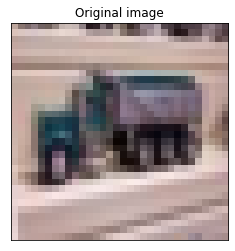

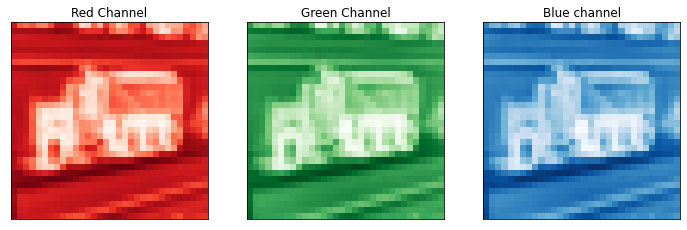

In [8]:
idx = np.random.randint(50000)
show_channels(X_train[idx])

# Lets now look at data classes

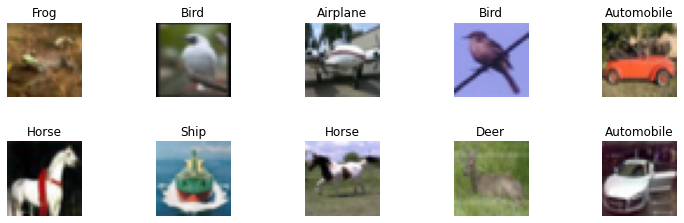

In [9]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
sample = np.random.choice(np.arange(50000),10) #to get random indices
 

fig, axes = plt.subplots(2, 5, figsize=(12,4))
axes = axes.ravel()

for i in range(10):
    idx = sample[i]
    axes[i].imshow(X_train[idx])
    axes[i].set_title(labels[y_train[idx][0]])
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)



# Data Preprocessing

In [10]:
# normalizing the data
X_train_norm = X_train / 255
X_test_norm = X_test / 255 

Lets pick up some value of the matrix of the image and see what difference has normalized made. 

In [11]:
print('Before normalizing - ',X_train[0][15][15])
print('After normalizing - ',X_train_norm[0][15][15])

Before normalizing -  [247 234 212]
After normalizing -  [0.96862745 0.91764706 0.83137255]


We can see that the number are now in the range of 0 to 1, which we got by dividing each obeservation by 255, which is the highest pixel value

In [12]:
#one hot encoding
num_classes = 10
y_train_oh = keras.utils.to_categorical(y_train,10)
y_test_oh = keras.utils.to_categorical(y_test,10)

Now similarly for labels, lets see what one hot encoding does to it

In [13]:
print('Before one hot encoding - ',y_train[0:2])
print('After one hot encoding - ',y_train_oh[0:2])

Before one hot encoding -  [[6]
 [9]]
After one hot encoding -  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


6 is represented as an array of size 10, with value of sixth element to be 1. 

# CNN Model (without augmentation)

In [14]:
#define the convnet
model = Sequential()

# CONV => POOL => DROPOUT
model.add(Conv2D(32, (3, 3),input_shape=X_train.shape[1:],activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => POOL => DROPOUT
model.add(Conv2D(64, (3, 3),activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTEN => DENSE => DROPOUT
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(Dense(num_classes,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_norm, y_train_oh, epochs=20, 
                    validation_data=(X_test_norm, y_test_oh))

Epoch 1/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5255 - accuracy: 0.4492 - val_loss: 1.2042 - val_accuracy: 0.5841
Epoch 2/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2257 - accuracy: 0.5652 - val_loss: 1.0609 - val_accuracy: 0.6302
Epoch 3/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.1009 - accuracy: 0.6123 - val_loss: 0.9613 - val_accuracy: 0.6716
Epoch 4/20
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0180 - accuracy: 0.6428 - val_loss: 0.9184 - val_accuracy: 0.6854
Epoch 5/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9574 - accuracy: 0.6642 - val_loss: 0.8677 - val_accuracy: 0.7032
Epoch 6/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9106 - accuracy: 0.6792 - val_loss: 0.8660 - val_accuracy: 0.6992
Epoch 7/20
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8732 - accuracy: 0.6927 - val_loss: 0.8518 - val_accuracy:

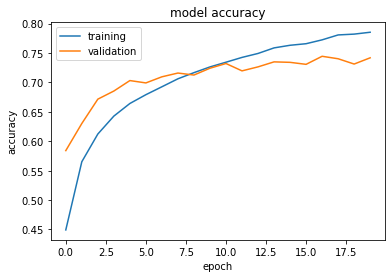

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

We are getting train accuracy of 0.7854, and test accuracy of 0.7419

SO, one thing is for sure, that the model is not overfitting the data :D

# CNN model with data augemntation

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


datagen.fit(X_train_norm)

history = model.fit_generator(datagen.flow(X_train_norm,y_train_oh),
                                epochs=25,
                                validation_data=(X_test_norm, y_test_oh))

Epoch 1/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8920 - accuracy: 0.6930 - val_loss: 0.7035 - val_accuracy: 0.7631
Epoch 2/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8696 - accuracy: 0.6997 - val_loss: 0.7466 - val_accuracy: 0.7474
Epoch 6/25
1563/1563 [==============================] - 32s 21ms/step - loss: 0.8717 - accuracy: 0.6991 - val_loss: 0.6758 - val_accuracy: 0.7721
Epoch 7/25
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8616 - accuracy: 0.7036 - val_loss: 0.6784 - val_accuracy: 0.7692
Epoch 8/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8561 - accuracy: 0.7023 - val_loss: 0.7090 - val_accuracy: 0.7560
Epoch 9/25
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8620 - accuracy: 0.7024 - val_loss: 0.6990 - val_accuracy: 0.7673
Epoch 10/25
1563/1563 [==============================] - 32s 20ms/step - loss: 0.8543 - accuracy: 0.7066 - val_loss: 0.6789 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()